# Loan Approval Prediction: End-to-End Classification Pipeline

This notebook implements a complete machine learning pipeline for loan approval prediction, including:
- Data cleaning and preprocessing
- Handling class imbalance with SMOTE
- Baseline logistic regression model
- Advanced models (Random Forest & XGBoost)
- Hyperparameter tuning
- Model comparison and deployment recommendations

## Project Overview
The goal is to build a robust classification model that can accurately predict loan approval decisions based on applicant characteristics such as income, credit score, education, employment status, and other relevant factors.

## 1. Import Libraries

In [1]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette('husl')

print(f"Random state set to: {RANDOM_STATE}")

Random state set to: 42


## 2. Load and Explore Data

In [2]:
# Load the dataset
df = pd.read_csv('loan_approval_dataset.csv')

# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# Remove loan_id column immediately as it's just an identifier
if 'loan_id' in df.columns:
    df = df.drop('loan_id', axis=1)
    print("Removed 'loan_id' column (identifier)")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print("\nFirst 5 rows:")
df.head()

Removed 'loan_id' column (identifier)
Dataset shape: (4269, 12)

Columns: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

First 5 rows:


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
# Basic dataset information
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nDataset Info:")
df.info()

DATASET OVERVIEW
Shape: (4269, 12)

Data types:
no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term    

In [4]:
# Check for missing values
print("MISSING VALUES ANALYSIS")
print("=" * 30)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values found in the dataset!")
    
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

MISSING VALUES ANALYSIS
No missing values found in the dataset!

Total missing values: 0


In [5]:
# Statistical summary
print("STATISTICAL SUMMARY")
print("=" * 20)
df.describe(include='all')

STATISTICAL SUMMARY


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269,4269,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269
unique,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Graduate,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved
freq,NaN,2144,2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2656
mean,2.498712,NaN,NaN,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,NaN
std,1.695910,NaN,NaN,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,NaN
min,0.000000,NaN,NaN,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,NaN
25%,1.000000,NaN,NaN,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,NaN
50%,3.000000,NaN,NaN,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,NaN
75%,4.000000,NaN,NaN,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,NaN


## 3. Target Variable Analysis

TARGET VARIABLE ANALYSIS
Target column: 'loan_status'

Target variable distribution:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Target variable percentages:
loan_status
Approved    62.215976
Rejected    37.784024
Name: proportion, dtype: float64


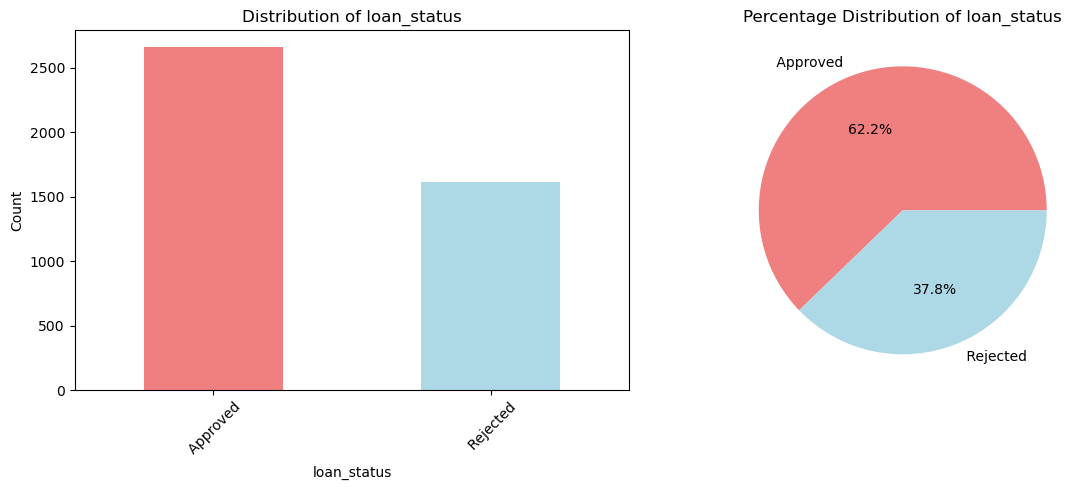


Class Imbalance Analysis:
Minority class percentage: 37.8%
 Dataset shows class imbalance - will need to address this!


In [6]:
# Identify target column
target_col = 'loan_status'

print(f"TARGET VARIABLE ANALYSIS")
print(f"=" * 30)
print(f"Target column: '{target_col}'")
print(f"\nTarget variable distribution:")
print(df[target_col].value_counts())
print(f"\nTarget variable percentages:")
print(df[target_col].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[target_col].value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title(f'Percentage Distribution of {target_col}')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Check for class imbalance
class_counts = df[target_col].value_counts()
minority_class_pct = (class_counts.min() / class_counts.sum()) * 100
print(f"\nClass Imbalance Analysis:")
print(f"Minority class percentage: {minority_class_pct:.1f}%")
if minority_class_pct < 40:
    print(" Dataset shows class imbalance - will need to address this!")
else:
    print("Dataset is relatively balanced")

## 4. Feature Analysis

In [7]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target from features if it's in the lists
if target_col in categorical_cols:
    categorical_cols.remove(target_col)
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print("FEATURE ANALYSIS")
print("=" * 20)
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Target column: {target_col}")



FEATURE ANALYSIS
Categorical columns (2): ['education', 'self_employed']
Numerical columns (9): ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Target column: loan_status


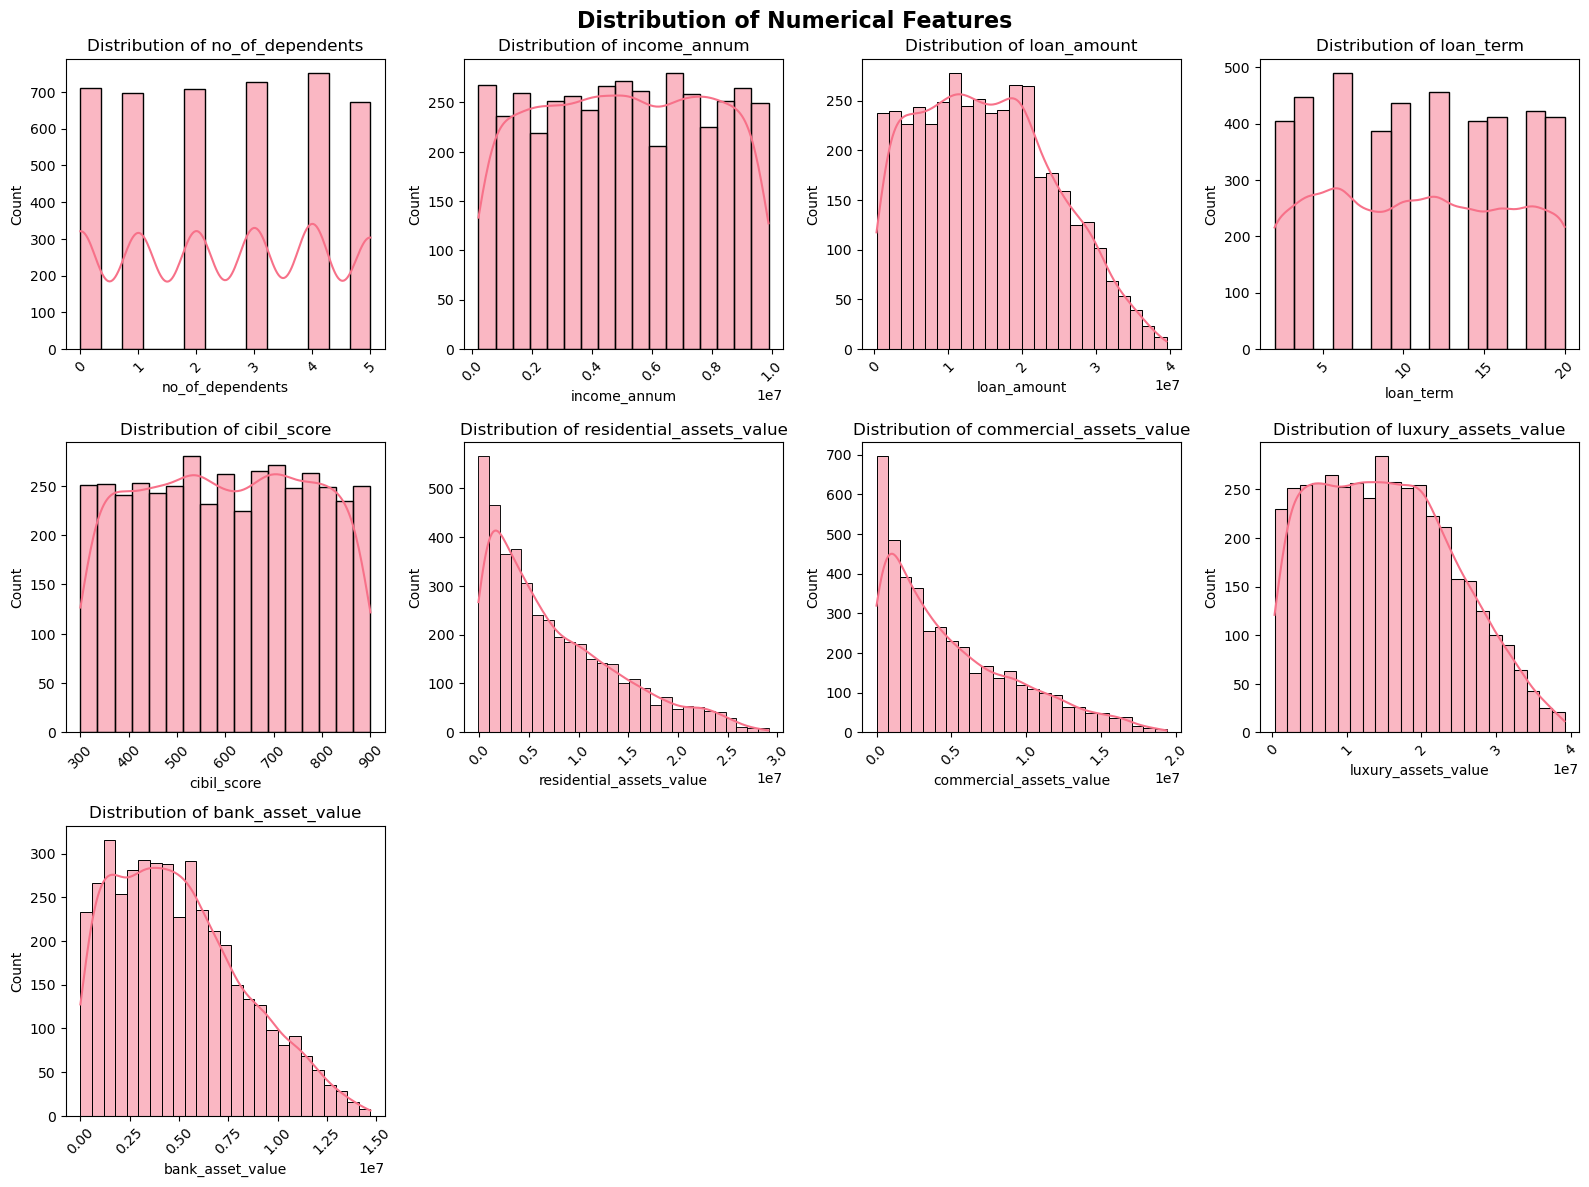

In [8]:
# Visualize numerical features
if numerical_cols:
    n_cols = min(4, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    
    # Handle different subplot configurations
    if n_rows == 1 and n_cols == 1:
        axes = [axes]  # Make it a list for consistent indexing
    elif n_rows == 1:
        axes = axes  # Already an array for single row
    # For multiple rows, axes is already a 2D array
    
    fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(numerical_cols):
        # Calculate subplot position
        if n_rows == 1:
            ax = axes[i]
        else:
            row, col_idx = divmod(i, n_cols)
            ax = axes[row, col_idx]
        
        # Create histogram with KDE
        sns.histplot(data=df, x=col, kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(numerical_cols), n_rows * n_cols):
        if n_rows == 1:
            if i < n_cols:
                axes[i].set_visible(False)
        else:
            row, col_idx = divmod(i, n_cols)
            axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns to visualize.")

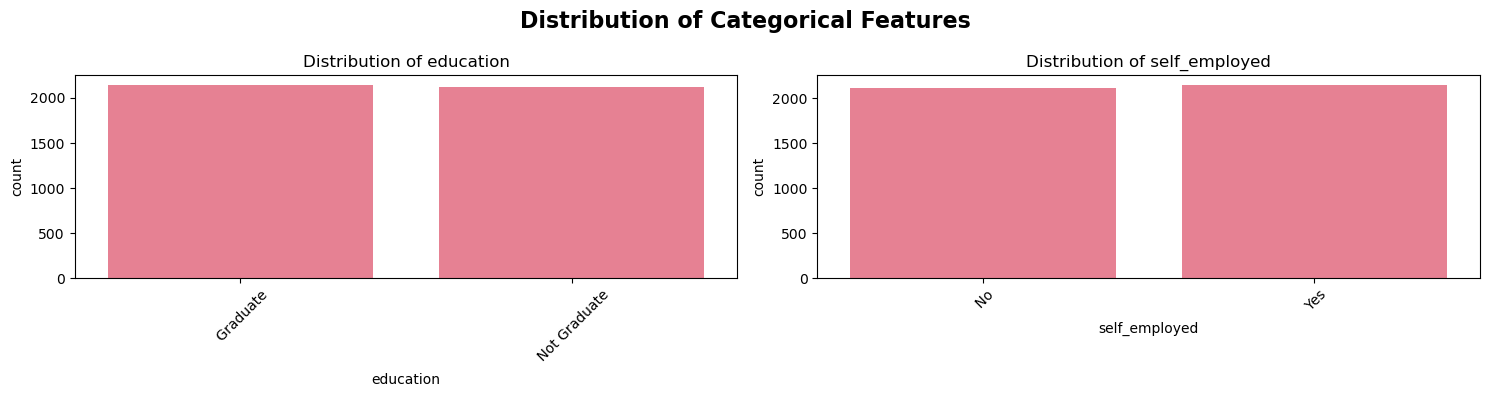

In [9]:
# Visualize categorical features
if categorical_cols:
    n_cols = min(3, len(categorical_cols))
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    
    # Handle different subplot configurations
    if n_rows == 1 and n_cols == 1:
        axes = [axes]  # Make it a list for consistent indexing
    elif n_rows == 1:
        axes = axes  # Already an array for single row
    # For multiple rows, axes is already a 2D array
    
    fig.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(categorical_cols):
        # Calculate subplot position
        if n_rows == 1:
            ax = axes[i]
        else:
            row, col_idx = divmod(i, n_cols)
            ax = axes[row, col_idx]
        
        # Create count plot
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(categorical_cols), n_rows * n_cols):
        if n_rows == 1:
            if i < n_cols:
                axes[i].set_visible(False)
        else:
            row, col_idx = divmod(i, n_cols)
            axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns to visualize.")

## 5. Data Preprocessing

In [10]:
# Create a copy for preprocessing
df_processed = df.copy()

print("DATA PREPROCESSING STEPS")
print("=" * 30)

# Step 1: Handle missing values
missing_before = df_processed.isnull().sum().sum()
print(f"1. Handling missing values (total missing: {missing_before})")

if missing_before > 0:
    # For categorical columns: fill with mode
    cat_cols_with_missing = [col for col in categorical_cols 
                           if col in df_processed.columns and df_processed[col].isnull().any()]
    for col in cat_cols_with_missing:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"   - Filled {col} missing values with mode: {mode_val}")
    
    # For numerical columns: fill with median
    num_cols_with_missing = [col for col in numerical_cols 
                           if col in df_processed.columns and df_processed[col].isnull().any()]
    for col in num_cols_with_missing:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"   - Filled {col} missing values with median: {median_val}")
else:
    print("   - No missing values to handle")

missing_after = df_processed.isnull().sum().sum()
print(f"   - Missing values after handling: {missing_after}")

print(f"\n2. Dataset shape after preprocessing: {df_processed.shape}")
print(f"   Original shape: {df.shape}")


DATA PREPROCESSING STEPS
1. Handling missing values (total missing: 0)
   - No missing values to handle
   - Missing values after handling: 0

2. Dataset shape after preprocessing: (4269, 12)
   Original shape: (4269, 12)


In [11]:
# Prepare features and target
print("FEATURE AND TARGET PREPARATION")
print("=" * 32)

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(df_processed[target_col])
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(f"Target variable '{target_col}' encoded:")
print(f"Mapping: {target_mapping}")

# Prepare feature matrix X
X = df_processed.drop(columns=[target_col])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {list(X.columns)}")

FEATURE AND TARGET PREPARATION
Target variable 'loan_status' encoded:
Mapping: {' Approved': np.int64(0), ' Rejected': np.int64(1)}

Feature matrix shape: (4269, 11)
Target vector shape: (4269,)
Features: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("TRAIN-TEST SPLIT")
print("=" * 20)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Check class distribution
train_class_dist = pd.Series(y_train).value_counts()
test_class_dist = pd.Series(y_test).value_counts()

print(f"\nTraining set class distribution:")
for class_val, count in train_class_dist.items():
    class_name = le_target.inverse_transform([class_val])[0]
    pct = (count / len(y_train)) * 100
    print(f"   {class_name} ({class_val}): {count} ({pct:.1f}%)")

print(f"\nTest set class distribution:")
for class_val, count in test_class_dist.items():
    class_name = le_target.inverse_transform([class_val])[0]
    pct = (count / len(y_test)) * 100
    print(f"   {class_name} ({class_val}): {count} ({pct:.1f}%)")

TRAIN-TEST SPLIT
Training set size: 3415 samples
Test set size: 854 samples
Features: 11

Training set class distribution:
    Approved (0): 2125 (62.2%)
    Rejected (1): 1290 (37.8%)

Test set class distribution:
    Approved (0): 531 (62.2%)
    Rejected (1): 323 (37.8%)


## 6. Create Preprocessing Pipeline

In [14]:
# Update feature lists after preprocessing
categorical_cols = [col for col in categorical_cols if col in X.columns]
numerical_cols = [col for col in numerical_cols if col in X.columns]

print("CREATING PREPROCESSING PIPELINE")
print("=" * 35)

# Define transformers for different types of features
transformers = []

# Numerical features: impute missing values and scale
if numerical_cols:
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    transformers.append(('num', numerical_transformer, numerical_cols))
    print(f"Numerical transformer: Impute + StandardScaler for {len(numerical_cols)} features")

# Categorical features: impute missing values and one-hot encode
if categorical_cols:
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    transformers.append(('cat', categorical_transformer, categorical_cols))
    print(f"Categorical transformer: Impute + OneHotEncoder for {len(categorical_cols)} features")

# Create the column transformer
if transformers:
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough'
    )
    print(f"\nPreprocessing pipeline created with {len(transformers)} transformer(s)")
else:
    preprocessor = ColumnTransformer(
        transformers=[('passthrough', 'passthrough', list(X.columns))]
    )
    print("\nSimple passthrough pipeline created")

# Fit and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nPreprocessed data shapes:")
print(f"   Training: {X_train_processed.shape}")
print(f"   Test: {X_test_processed.shape}")

CREATING PREPROCESSING PIPELINE
Numerical transformer: Impute + StandardScaler for 9 features
Categorical transformer: Impute + OneHotEncoder for 2 features

Preprocessing pipeline created with 2 transformer(s)

Preprocessed data shapes:
   Training: (3415, 11)
   Test: (854, 11)


## 7. Handle Class Imbalance with SMOTE

In [16]:
# Check class distribution before SMOTE
print("CLASS IMBALANCE HANDLING")
print("=" * 25)

unique, counts = np.unique(y_train, return_counts=True)
class_dist_before = dict(zip(unique, counts))

print("Class distribution BEFORE SMOTE:")
for class_val, count in class_dist_before.items():
    class_name = le_target.inverse_transform([class_val])[0]
    pct = (count / len(y_train)) * 100
    print(f"   {class_name} ({class_val}): {count} samples ({pct:.1f}%)")

# Calculate imbalance ratio
majority_count = max(counts)
minority_count = min(counts)
imbalance_ratio = majority_count / minority_count
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

# Apply SMOTE if there's significant imbalance
if imbalance_ratio > 1.5:
    print(f"\nApplying SMOTE to balance classes...")
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
    
    # Check class distribution after SMOTE
    unique_after, counts_after = np.unique(y_train_balanced, return_counts=True)
    class_dist_after = dict(zip(unique_after, counts_after))
    
    print("\nClass distribution AFTER SMOTE:")
    for class_val, count in class_dist_after.items():
        class_name = le_target.inverse_transform([class_val])[0]
        pct = (count / len(y_train_balanced)) * 100
        print(f"   {class_name} ({class_val}): {count} samples ({pct:.1f}%)")
    
    print(f"\nTraining set size increased from {len(y_train)} to {len(y_train_balanced)} samples")
    
else:
    print(f"\nClasses are relatively balanced, skipping SMOTE")
    X_train_balanced = X_train_processed
    y_train_balanced = y_train

print(f"\nFinal training set shape: {X_train_balanced.shape}")
print(f"Final training targets shape: {y_train_balanced.shape}")

CLASS IMBALANCE HANDLING
Class distribution BEFORE SMOTE:
    Approved (0): 2125 samples (62.2%)
    Rejected (1): 1290 samples (37.8%)

Imbalance ratio: 1.65:1

Applying SMOTE to balance classes...

Class distribution AFTER SMOTE:
    Approved (0): 2125 samples (50.0%)
    Rejected (1): 2125 samples (50.0%)

Training set size increased from 3415 to 4250 samples

Final training set shape: (4250, 11)
Final training targets shape: (4250,)


## 8. Model Evaluation Function

In [17]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation function"""
    
    print(f"\n{model_name.upper()} EVALUATION")
    print("=" * (len(model_name) + 11))
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (weighted)")
    print(f"Recall:    {recall:.4f} (weighted)")
    print(f"F1-Score:  {f1:.4f} (weighted)")
    print(f"ROC-AUC:   {auc:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    target_names = [le_target.inverse_transform([i])[0] for i in range(len(le_target.classes_))]
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

## 9. Baseline Model: Logistic Regression

BASELINE MODEL: LOGISTIC REGRESSION
Logistic Regression model trained successfully
   Training samples: 4250
   Test samples: 854
   Features: 11

LOGISTIC REGRESSION EVALUATION
Accuracy:  0.9321
Precision: 0.9322 (weighted)
Recall:    0.9321 (weighted)
F1-Score:  0.9321 (weighted)
ROC-AUC:   0.9747

Classification Report:
              precision    recall  f1-score   support

    Approved       0.95      0.94      0.95       531
    Rejected       0.91      0.91      0.91       323

    accuracy                           0.93       854
   macro avg       0.93      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854



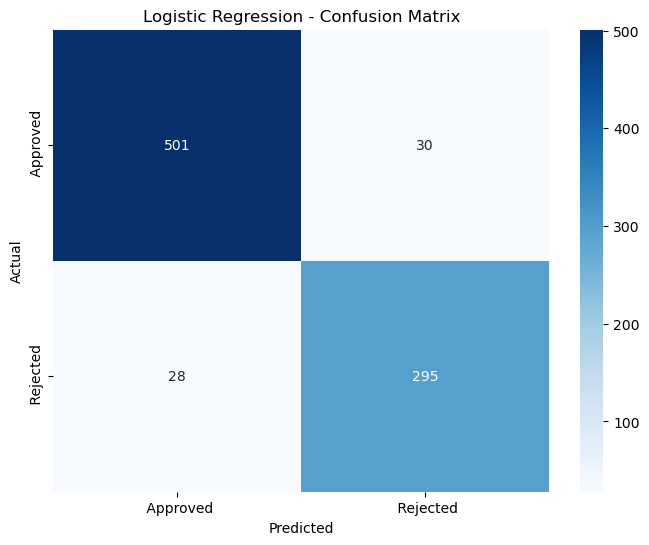

In [18]:
# Train baseline logistic regression model
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("=" * 35)

# Initialize and train the model
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_lr = lr_model.predict(X_test_processed)
y_pred_proba_lr = lr_model.predict_proba(X_test_processed)[:, 1]

print("Logistic Regression model trained successfully")
print(f"   Training samples: {len(y_train_balanced)}")
print(f"   Test samples: {len(y_test)}")
print(f"   Features: {X_train_balanced.shape[1]}")

# Evaluate baseline model
lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

## 10. Advanced Models: Random Forest & XGBoost

ADVANCED MODEL 1: RANDOM FOREST
Random Forest model trained successfully

RANDOM FOREST EVALUATION
Accuracy:  0.9813
Precision: 0.9814 (weighted)
Recall:    0.9813 (weighted)
F1-Score:  0.9812 (weighted)
ROC-AUC:   0.9982

Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.99      0.99       531
    Rejected       0.99      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



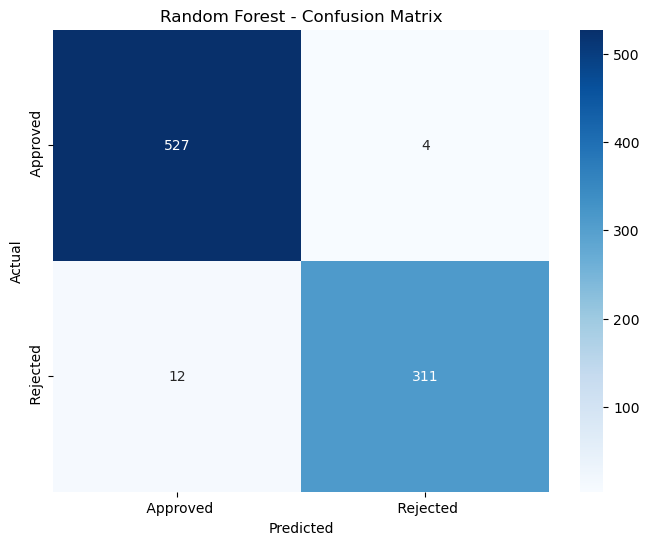

In [19]:
# Train Random Forest model
print("ADVANCED MODEL 1: RANDOM FOREST")
print("=" * 32)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_processed)
y_pred_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]

print("Random Forest model trained successfully")
rf_metrics = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")

ADVANCED MODEL 2: XGBOOST
XGBoost model trained successfully

XGBOOST EVALUATION
Accuracy:  0.9824
Precision: 0.9825 (weighted)
Recall:    0.9824 (weighted)
F1-Score:  0.9824 (weighted)
ROC-AUC:   0.9982

Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.99      0.99       531
    Rejected       0.99      0.97      0.98       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



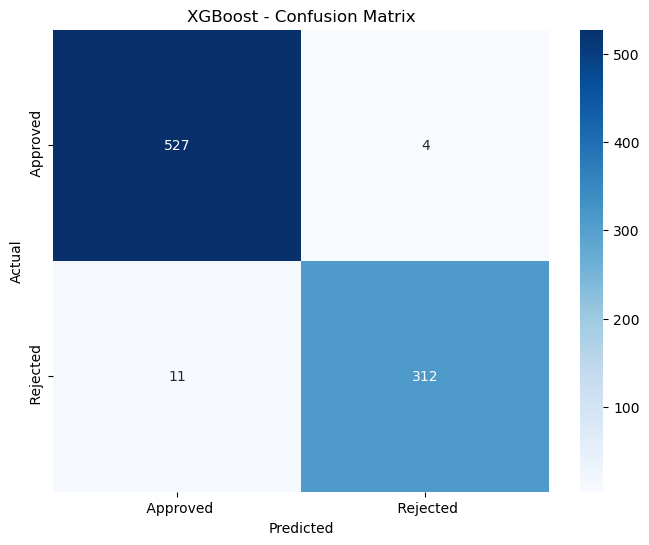

In [20]:
# Train XGBoost model
print("ADVANCED MODEL 2: XGBOOST")
print("=" * 25)

xgb_model = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=0
)
xgb_model.fit(X_train_balanced, y_train_balanced)

y_pred_xgb = xgb_model.predict(X_test_processed)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

print("XGBoost model trained successfully")
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

## 11. Model Comparison

MODEL COMPARISON (BEFORE TUNING)
                     accuracy  precision  recall      f1     auc
Logistic Regression    0.9321     0.9322  0.9321  0.9321  0.9747
Random Forest          0.9813     0.9814  0.9813  0.9812  0.9982
XGBoost                0.9824     0.9825  0.9824  0.9824  0.9982


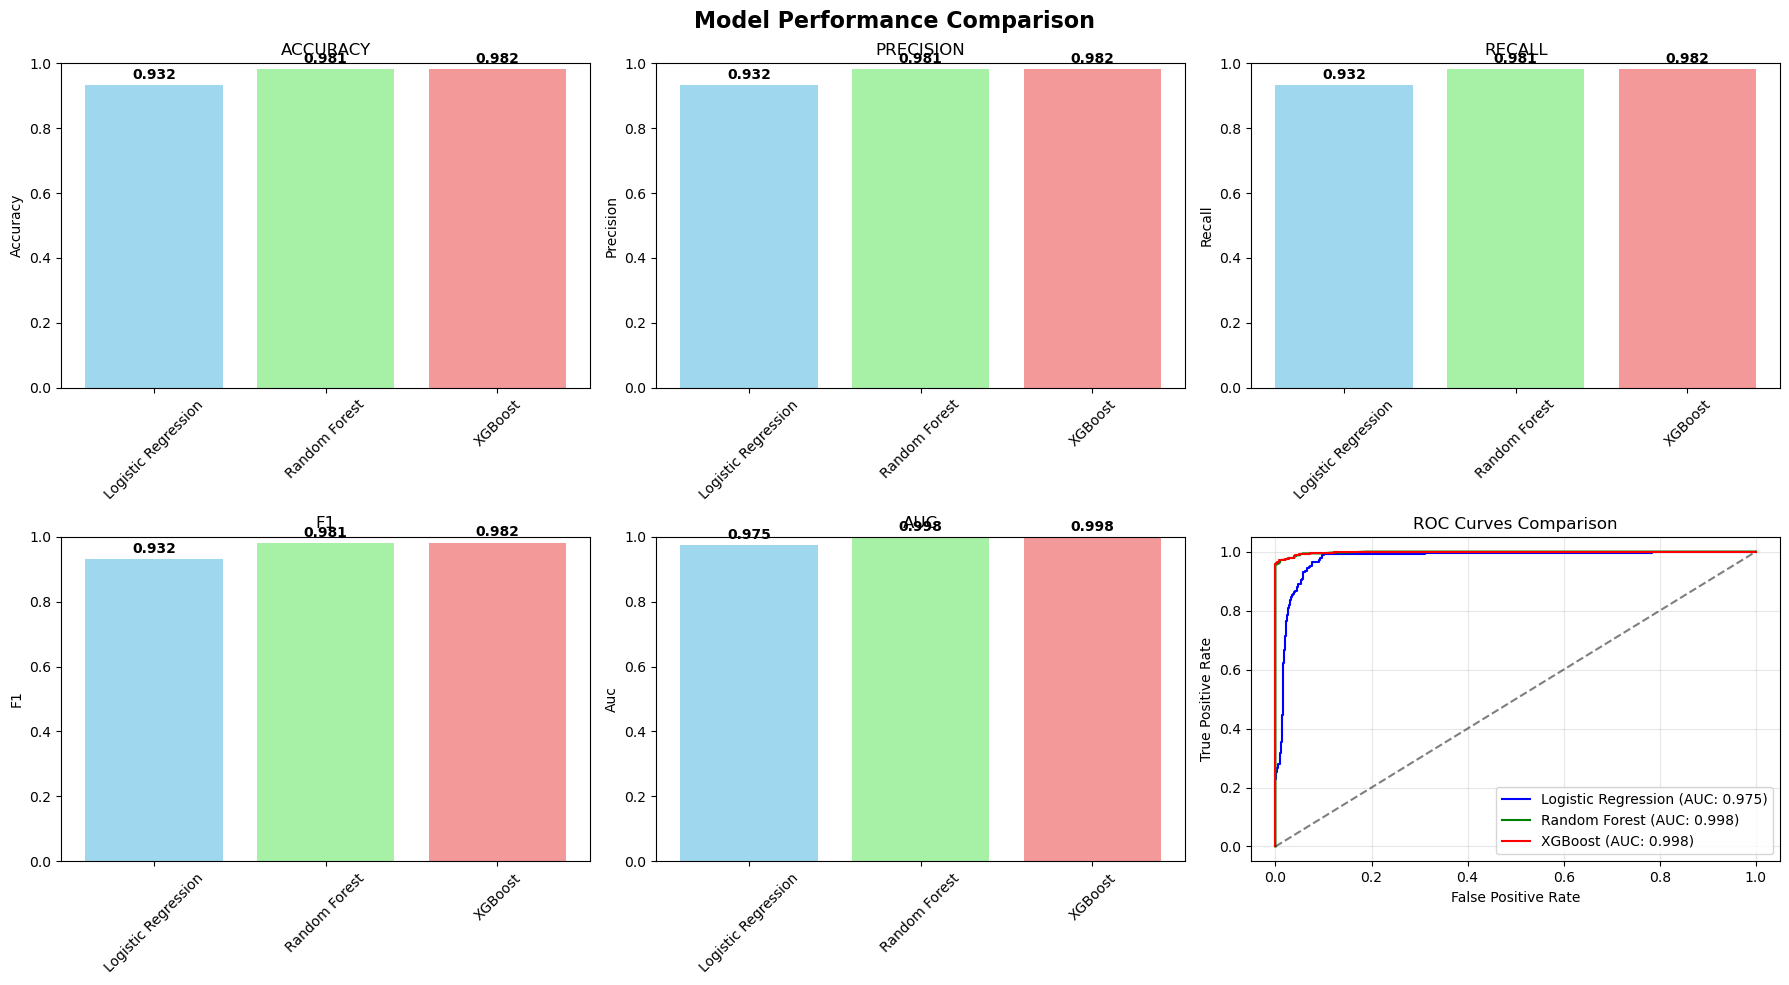


Best model by F1-score: XGBoost (0.9824)
Best model by ROC-AUC: XGBoost (0.9982)


In [21]:
# Compare models before tuning
print("MODEL COMPARISON (BEFORE TUNING)")
print("=" * 33)

models_comparison = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}).T

print(models_comparison.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    
    values = [models_comparison.loc[model, metric] for model in model_names]
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    
    bars = ax.bar(model_names, values, color=colors, alpha=0.8)
    ax.set_title(f'{metric.upper()}')
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.tick_params(axis='x', rotation=45)

# ROC Curves comparison
ax = axes[1, 2]
models_roc = [
    (lr_model, "Logistic Regression", 'blue'),
    (rf_model, "Random Forest", 'green'),
    (xgb_model, "XGBoost", 'red')
]

for model, name, color in models_roc:
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, color=color, label=f'{name} (AUC: {auc_score:.3f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best performing model
best_model_f1 = models_comparison['f1'].idxmax()
best_model_auc = models_comparison['auc'].idxmax()

print(f"\nBest model by F1-score: {best_model_f1} ({models_comparison.loc[best_model_f1, 'f1']:.4f})")
print(f"Best model by ROC-AUC: {best_model_auc} ({models_comparison.loc[best_model_auc, 'auc']:.4f})")

## 12. Hyperparameter Tuning

HYPERPARAMETER TUNING: RANDOM FOREST
Parameter grid: {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Random Forest tuning completed!
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation F1 score: 0.9826

RANDOM FOREST (TUNED) EVALUATION
Accuracy:  0.9801
Precision: 0.9801 (weighted)
Recall:    0.9801 (weighted)
F1-Score:  0.9801 (weighted)
ROC-AUC:   0.9982

Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.99      0.98       531
    Rejected       0.98      0.97      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



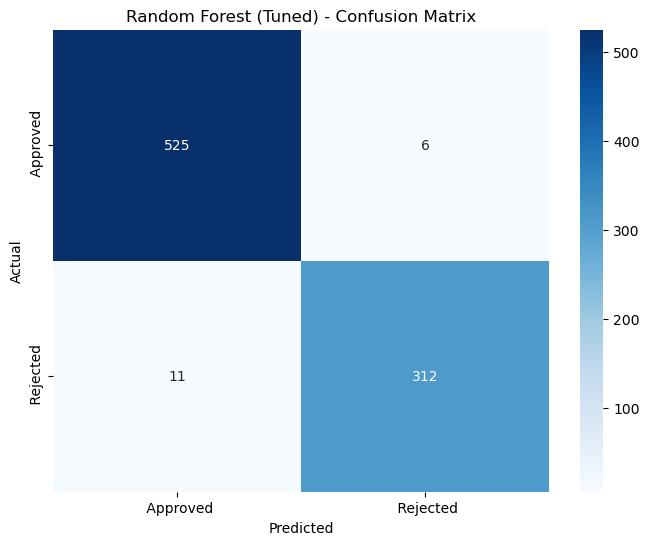

In [22]:
# Hyperparameter tuning for Random Forest
print("HYPERPARAMETER TUNING: RANDOM FOREST")
print("=" * 37)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print(f"Parameter grid: {rf_param_grid}")

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Random Forest hyperparameter tuning...")
rf_grid.fit(X_train_balanced, y_train_balanced)

print(f"\nRandom Forest tuning completed!")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation F1 score: {rf_grid.best_score_:.4f}")

best_rf = rf_grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_processed)
y_pred_proba_rf_tuned = best_rf.predict_proba(X_test_processed)[:, 1]

rf_tuned_metrics = evaluate_model(y_test, y_pred_rf_tuned, y_pred_proba_rf_tuned, "Random Forest (Tuned)")

HYPERPARAMETER TUNING: XGBOOST
Parameter grid: {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}

Starting XGBoost hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

XGBoost tuning completed!
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best cross-validation F1 score: 0.9847

XGBOOST (TUNED) EVALUATION
Accuracy:  0.9778
Precision: 0.9778 (weighted)
Recall:    0.9778 (weighted)
F1-Score:  0.9777 (weighted)
ROC-AUC:   0.9983

Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.99      0.98       531
    Rejected       0.98      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854



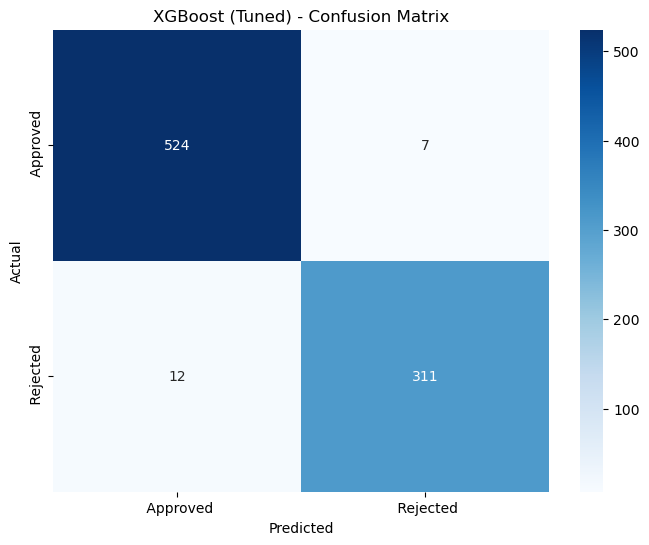

In [24]:
# Hyperparameter tuning for XGBoost
print("HYPERPARAMETER TUNING: XGBOOST")
print("=" * 31)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

print(f"Parameter grid: {xgb_param_grid}")

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0),
    xgb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nStarting XGBoost hyperparameter tuning...")
xgb_grid.fit(X_train_balanced, y_train_balanced)

print(f"\nXGBoost tuning completed!")
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation F1 score: {xgb_grid.best_score_:.4f}")

best_xgb = xgb_grid.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test_processed)
y_pred_proba_xgb_tuned = best_xgb.predict_proba(X_test_processed)[:, 1]

xgb_tuned_metrics = evaluate_model(y_test, y_pred_xgb_tuned, y_pred_proba_xgb_tuned, "XGBoost (Tuned)")

## 13. Final Model Comparison and Selection

In [25]:
# Compare all models (original and tuned)
print("FINAL MODEL COMPARISON")
print("=" * 22)

final_comparison = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'Random Forest (Tuned)': rf_tuned_metrics,
    'XGBoost': xgb_metrics,
    'XGBoost (Tuned)': xgb_tuned_metrics
}).T

print(final_comparison.round(4))

# Identify the best final model
best_final_model = final_comparison['f1'].idxmax()
best_final_f1 = final_comparison.loc[best_final_model, 'f1']
best_final_auc = final_comparison.loc[best_final_model, 'auc']

print(f"\nBEST PERFORMING MODEL: {best_final_model}")
print(f"   F1-Score: {best_final_f1:.4f}")
print(f"   ROC-AUC: {best_final_auc:.4f}")
print(f"   Accuracy: {final_comparison.loc[best_final_model, 'accuracy']:.4f}")

# Performance improvement summary
baseline_f1 = lr_metrics['f1']
improvement = best_final_f1 - baseline_f1
improvement_pct = (improvement / baseline_f1) * 100

print(f"\nPERFORMANCE IMPROVEMENT:")
print(f"Baseline (Logistic Regression) F1: {baseline_f1:.4f}")
print(f"Best model F1: {best_final_f1:.4f}")
print(f"Improvement: {improvement:+.4f} ({improvement_pct:+.1f}%)")

FINAL MODEL COMPARISON
                       accuracy  precision  recall      f1     auc
Logistic Regression      0.9321     0.9322  0.9321  0.9321  0.9747
Random Forest            0.9813     0.9814  0.9813  0.9812  0.9982
Random Forest (Tuned)    0.9801     0.9801  0.9801  0.9801  0.9982
XGBoost                  0.9824     0.9825  0.9824  0.9824  0.9982
XGBoost (Tuned)          0.9778     0.9778  0.9778  0.9777  0.9983

BEST PERFORMING MODEL: XGBoost
   F1-Score: 0.9824
   ROC-AUC: 0.9982
   Accuracy: 0.9824

PERFORMANCE IMPROVEMENT:
Baseline (Logistic Regression) F1: 0.9321
Best model F1: 0.9824
Improvement: +0.0503 (+5.4%)
